In [1]:
#-----------------------------------------------------------------------------
#    Every workflow starts by importing all the neccessary Python libraries that
# you will be using within your script.
#-----------------------------------------------------------------------------
%matplotlib inline
import os
import numpy as np
import cv2
import matplotlib
from plantcv import plantcv as pcv

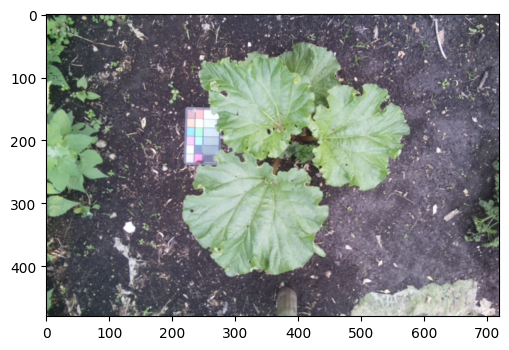

In [2]:
#-----------------------------------------------------------------------------
#   Debug is first set to 'plot' so that the output image of each function gets 
# displayed in Jupyter. Next we set img_file to the filename of our captured 
# image. Note that the image must either be in the same folder as this workflow
# or you must provide the full path to the image. Lastly, the given image is 
# read into our script.
#-----------------------------------------------------------------------------
pcv.params.debug = 'plot'
img_file = 'visExample.jpg'
img, path, filename = pcv.readimage(filename=img_file, mode='rgb')

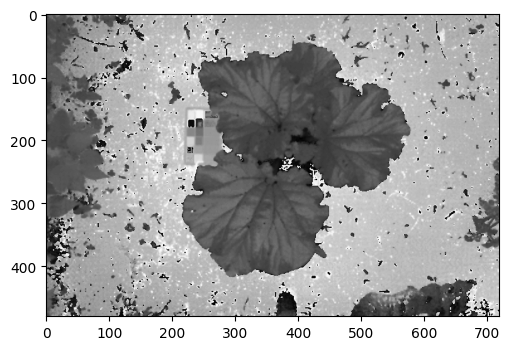

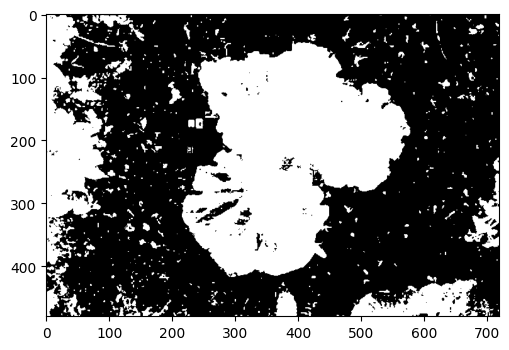

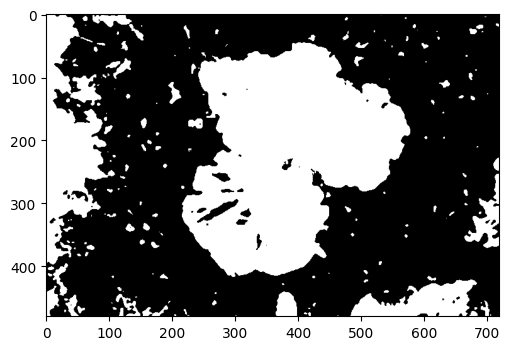

In [3]:
#-----------------------------------------------------------------------------
#    Here we create a mask with the goal of removing as much background as
# possible. First we extract the hue channel from the HSV conversion of 
# our RGB image. Next, adjust the threshold value to remove as much background
# as you can. The blur at the end removes noise from the image. Note that the
# object type is to specify whether the plant is lighter or darker than the 
# the surrounding background.
#-----------------------------------------------------------------------------
h = pcv.rgb2gray_hsv(rgb_img=img, channel='h')
h_thresh = pcv.threshold.binary(gray_img=h, threshold=75, max_value=255, object_type='dark')
h_mblur = pcv.median_blur(gray_img=h_thresh, ksize=5)

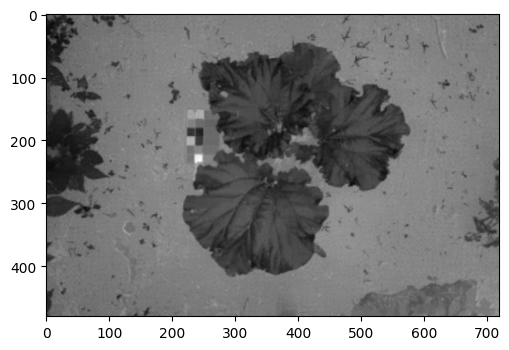

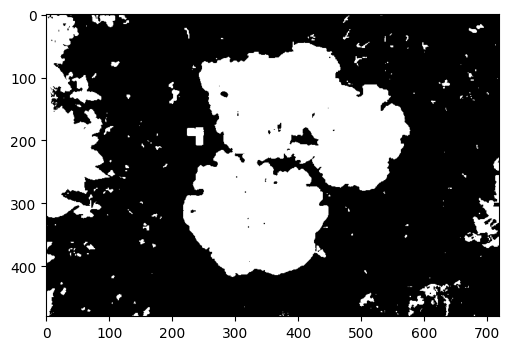

In [4]:
#-----------------------------------------------------------------------------
#    PlantCV has a number of automatic thresholding functions that you can 
# make use of, here we use them on the extracted green-magenta channel of the
# LAB colour space. We've included all of them here for you to try, simply 
# uncomment the one you want to use and comment the rest. If none of them 
# produce satisfactory results, use a binary threshold like above. 
#-----------------------------------------------------------------------------
a = pcv.rgb2gray_lab(rgb_img=img, channel='a')
a_thresh = pcv.threshold.otsu(gray_img=a, max_value=255, object_type='dark')
#a_thresh = pcv.threshold.mean(a, 255, 'dark')
#a_thresh = pcv.threshold.triangle(a, 255, 'dark', xstep=1) # Adjust xstep if needed

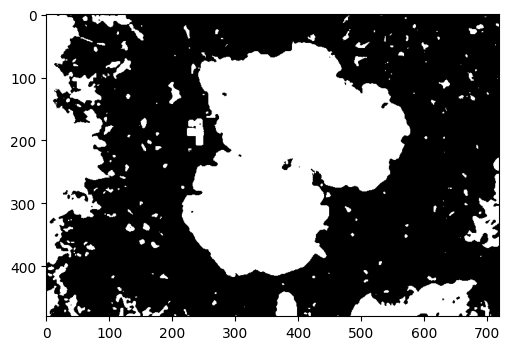

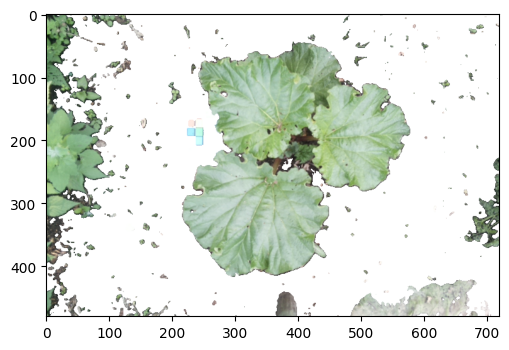

In [5]:
#-----------------------------------------------------------------------------
#    In this step we combine the thresholded images into a single image to
# create a mask, then use it to mask the original image. By extracting and 
# thresholding multiple colour channels we can better isolate the plant from 
# the background. Since different parts of the plant may be lost in these 
# thresholds, combining the thresholded images allows us produce a final mask 
# in which the plant is whole.
#-----------------------------------------------------------------------------
ha = pcv.logical_or(bin_img1=h_mblur, bin_img2=a_thresh)
#filled = pcv.fill_holes(ha)   # filling holes is an optional step and should be used sparingly
masked = pcv.apply_mask(img=img, mask=ha, mask_color='white')

At this point we were able to separate the plant from the background reasonably well using only two thresholded colour space channels. Your captured image may require the thresholding and combination of more colour space channels. If need be you may add more thresholds of HSV or LAB colour space channels in order to produce your disired results.

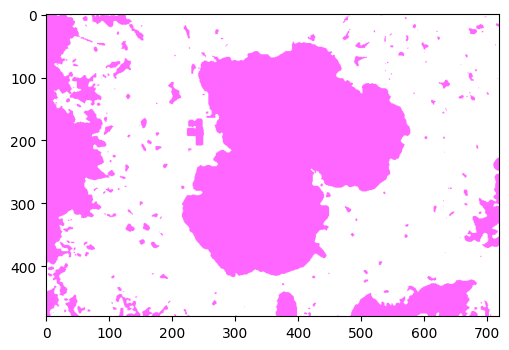

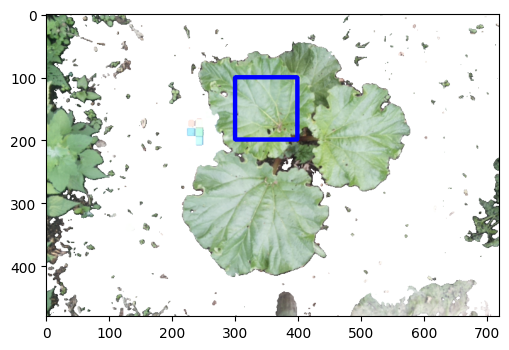

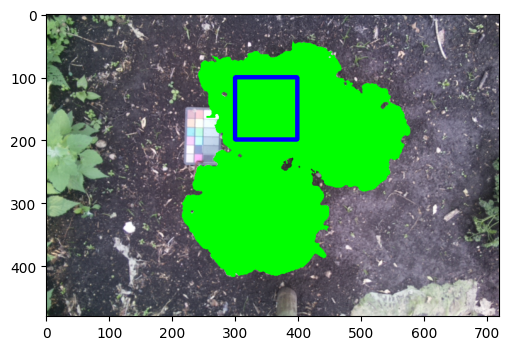

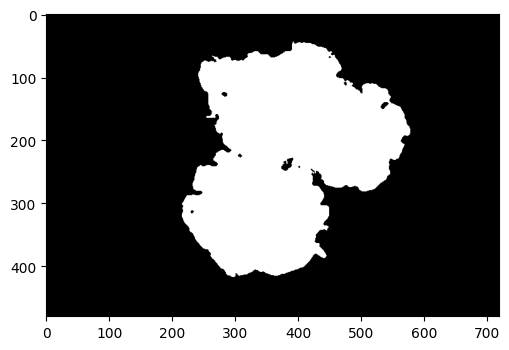

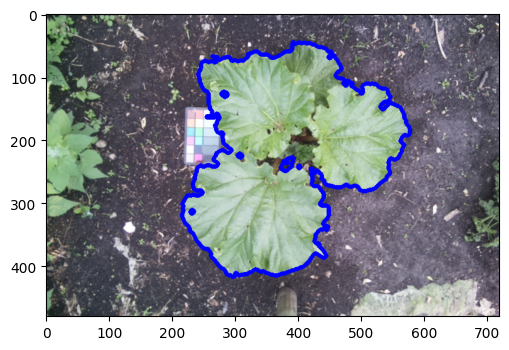

In [6]:
#-----------------------------------------------------------------------------
#    Now that we have the plant separated from the background we need to select
# only the plant for analysis. First we identify all the object within the 
# masked image, then we define a region of interest (ROI) containing our plant. 
# Afterwards we keep only the objects within that ROI then combine all the 
# kept objects into a single object
#-----------------------------------------------------------------------------
id_objects, obj_hierarchy = pcv.find_objects(img=masked, mask=ha)

roi1, roi_hierarchy= pcv.roi.rectangle(img=masked, x=300, y=100, h=100, w=100)
roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi1, 
                                                               roi_hierarchy=roi_hierarchy, 
                                                               object_contour=id_objects, 
                                                               obj_hierarchy=obj_hierarchy,
                                                               roi_type='partial')

obj, mask = pcv.object_composition(img=img, contours=roi_objects, hierarchy=hierarchy3)

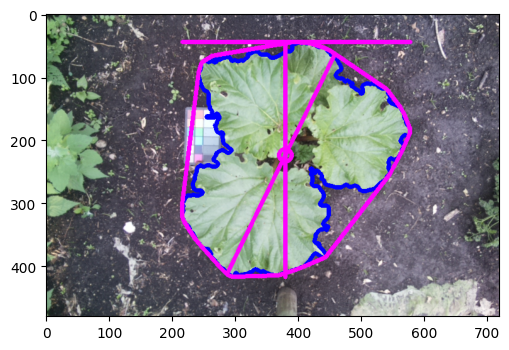

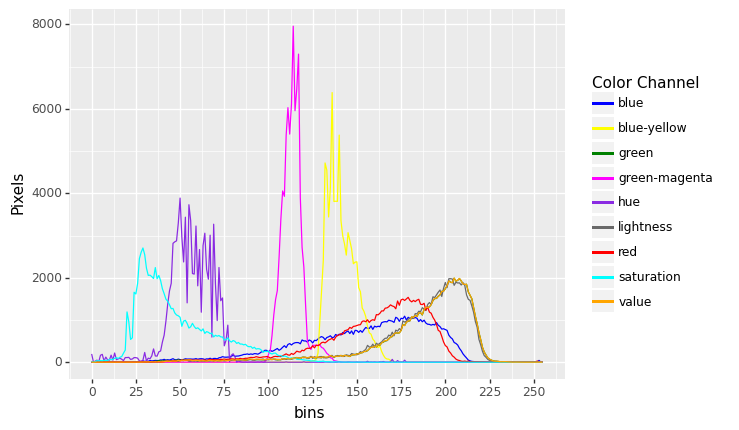

<ggplot: (8750861764976)>


NameError: name 'args' is not defined

In [7]:
#-----------------------------------------------------------------------------
#    The last step of our workflow is to analyze the properties of our plant. 
# PlantCV provides several functions to do this after which all the results
# will be saved in a JSON file.
#-----------------------------------------------------------------------------

# Shape properties of plant
analysis_image = pcv.analyze_object(img=img, obj=obj, mask=mask)

# Shape properties relative to boundry line (not needed for top down view)
#boundary_img1 = pcv.analyze_bound_horizontal(img=img, obj=obj, mask=mask, line_position=1680)

# Colour properties
color_histogram = pcv.analyze_color(rgb_img=img, mask=kept_mask, hist_plot_type='all')

# Print results of the analysis
pcv.print_results(filename=args.result)